# Azure ML Studio Tutorial: Image Classification with CIFAR-10

This tutorial walks you through training a simple convolutional neural network (CNN) on the CIFAR-10 dataset using PyTorch in Azure ML Studio.

We will:
- Load and preprocess the CIFAR-10 dataset
- Define a basic CNN model
- Train the model on Azure ML
- Log metrics and register the model

This notebook is designed to be run inside an **Azure ML Compute Instance** or with a **Compute Cluster** using an Azure ML experiment.


In [1]:
!pip install --upgrade azure-ai-ml torchvision torch matplotlib numpy

import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from azureml.core import Workspace, Experiment, Run
from azureml.core.model import Model

print("Libraries imported.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 78.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 134.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 98.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 24.2 MB/s eta 0:00:00
     

## Load and Preprocess CIFAR-10 Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)


100%|██████████| 170M/170M [00:01<00:00, 106MB/s]  


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Define CNN Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


## Define Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the Model and Log with Azure ML

In [11]:
run = Run.get_context()
losses = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    run.log("loss", avg_loss)

print('Finished Training')


Epoch 1, Loss: 0.6772
Attempted to log scalar metric loss:
0.6771698769782205
Epoch 2, Loss: 0.6127
Attempted to log scalar metric loss:
0.6127491049144579
Epoch 3, Loss: 0.5511
Attempted to log scalar metric loss:
0.5510960305133439
Epoch 4, Loss: 0.4958
Attempted to log scalar metric loss:
0.49578193841916524
Epoch 5, Loss: 0.4341
Attempted to log scalar metric loss:
0.43414177591233605
Finished Training


## Save and Register the Model

In [12]:
os.makedirs("outputs", exist_ok=True)
torch.save(model.state_dict(), "outputs/cifar_model.pth")

run.upload_file("outputs/cifar_model.pth", "outputs/cifar_model.pth")
run.complete()


Attempted to track file outputs/cifar_model.pth at outputs/cifar_model.pth


*Check Predictions *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


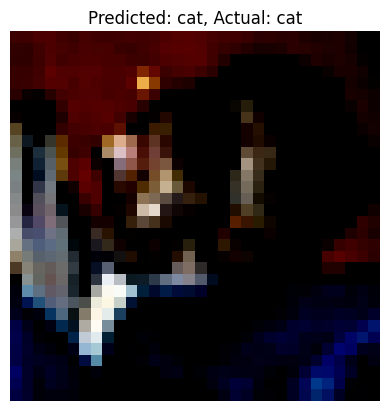

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


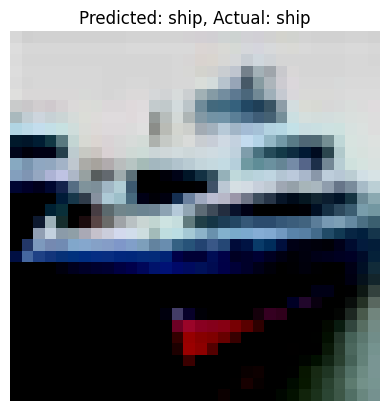

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


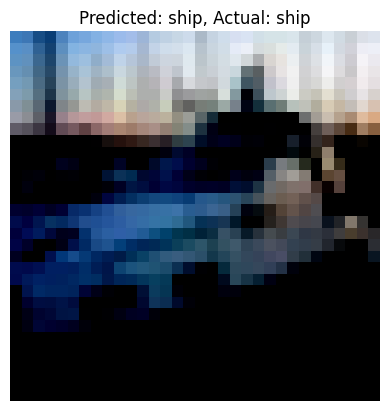

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


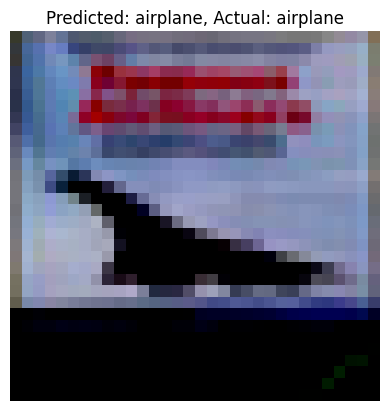

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


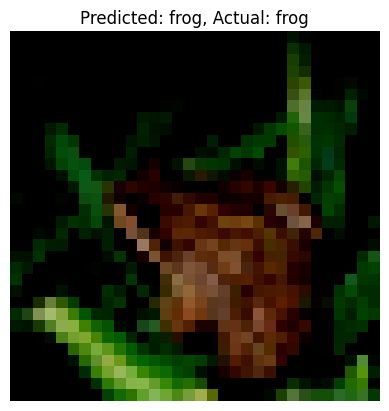

In [13]:

import matplotlib.pyplot as plt
import numpy as np

# Helper: plot a few test images with predictions
def show_predictions(model, testloader, classes, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
                plt.title(f"Predicted: {classes[preds[i]]}, Actual: {classes[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

# Call this function to visualize predictions
show_predictions(model, testloader, classes, device)


Plot Metrics

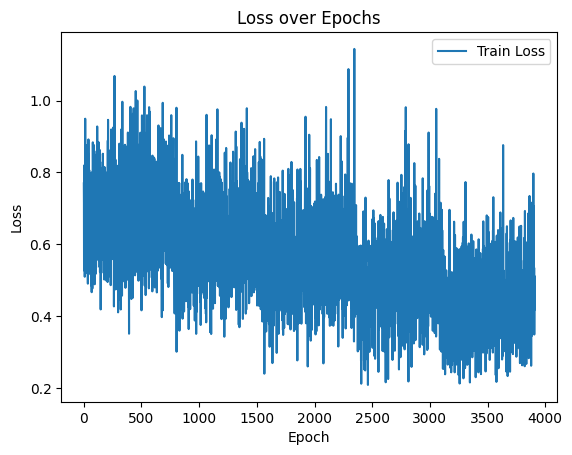

In [17]:

# Plot loss
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


In [18]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 2.2.6)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/anaconda/envs/azureml_py38/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/anaconda/envs/azureml_py38/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File 

AttributeError: _ARRAY_API not found

In [ ]:

correct = [0] * len(classes)
total = [0] * len(classes)

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            total[label] += 1
            if label == prediction:
                correct[label] += 1

class_accuracy = [100 * c / t if t != 0 else 0 for c, t in zip(correct, total)]

plt.figure(figsize=(10,5))
plt.bar(classes, class_accuracy)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy')
plt.xticks(rotation=45)
plt.show()
